In [ ]:
# Primary Goal: Abstract some generic "over all waves" baseline features
# E.g. al_scale/lr_scale
# Also generic immigration sentiment
# Maybe also Don't Knowness, Pol Attention, Being Wrong about Political Roles

# Secondary Goal: Transform features to have better distributions (norm/uniform)



# Initial pitch: Sparse PCA to split al from lr, factor analysis to remove major component for immig sentiment




In [ ]:
# TODO:
# Compare results with weighted PCA/missing values
# wpca?

# Try gaussianize function instead of manual box-cox
# http://scottclowe.com/2016-03-12-boxcox-feature-gaussianisation/
# https://github.com/gregversteeg/gaussianize (doesn't look so good!)
# https://github.com/akalino/Gaussianize

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [4]:
dataset_name = "W13_comb"

In [5]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
print("BES_Panel", BES_Panel.shape )

####

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_Panel (68625, 5150)
BES_numeric (68625, 4969)
var_type (5150, 13)
BES_non_numeric (68625, 126)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)
Wall time: 18min 25s


In [ ]:
### Generalised Immigration Sentiment

In [156]:
temp = BES_Panel[[x for x in BES_Panel.columns if "eumii" in x.lower()]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
eumii_vars = temp3

temp = BES_Panel[[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
mii_vars = temp3

BES_immig = pd.concat( [ BES_reduced[[x for x in BES_reduced.columns if "imm" in x.lower()]].drop("miilabelW1_immigration",axis=1), eumii_vars, mii_vars], axis=1)
BES_immig = BES_immig.drop([x for x in BES_immig.columns if "discrim" in x], axis=1)
# fill NaNs in eumii/mii vars with mean
BES_immig[BES_immig.columns[BES_immig.isnull().any()]] = \
    BES_immig[BES_immig.columns[BES_immig.isnull().any()]].apply(lambda x: x.fillna(x.mean()))

Wall time: 43.2 s


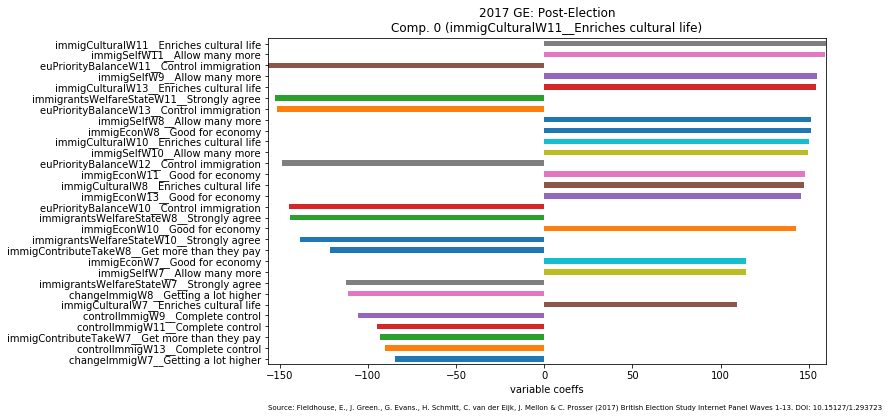

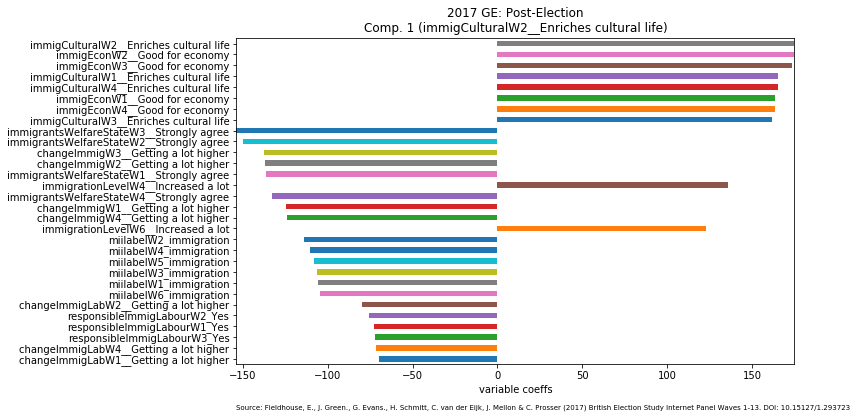

In [157]:
%%time
Treatment = "pan-dataset-values" + "_immigration"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    
    

clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

n_components = BES_std.shape[1]
n_components = 2

#decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp = SparsePCA(n_components = n_components, alpha = 32)
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [158]:
comp_dict[0].sort_values(by='comp_absmag', ascending=False).iloc[0:50]

,components_,comp_absmag
immigCulturalW11__Enriches cultural life,159.785423,159.785423
immigSelfW11__Allow many more,159.350568,159.350568
euPriorityBalanceW11__Control immigration,-156.648431,156.648431
immigSelfW9__Allow many more,154.781529,154.781529
immigCulturalW13__Enriches cultural life,153.990691,153.990691
immigrantsWelfareStateW11__Strongly agree,-152.718276,152.718276
euPriorityBalanceW13__Control immigration,-151.751985,151.751985
immigSelfW8__Allow many more,151.590126,151.590126
immigEconW8__Good for economy,151.234659,151.234659
immigCulturalW10__Enriches cultural life,150.314580,150.314580


In [159]:
# BES_decomp[0].hist(bins=100);
genImmigSentiment = BES_decomp[0].copy()

'../BES_analysis_code/small data files\\'

In [ ]:
## Generalised lr/al sentiments

In [160]:
# lr  leftRight, redistSelf, cutsTooFar
# al immigEcon, immigCultural, immigSelf, immigrantsWelfareState, overseasAid
al_lr_values = [x for x in BES_reduced.columns if re.match("(al|lr)\d|redistSelf",x)]
                                                           #|govtHandouts|cutsTooFar|immigSelf|immigEcon|immigCultural|immigrantsWelfareState|overseasAid",x)]
BES_vals = BES_reduced[al_lr_values]

In [161]:
Treatment = "pan-dataset-values" + "_allr_values"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

Wall time: 4.76 s


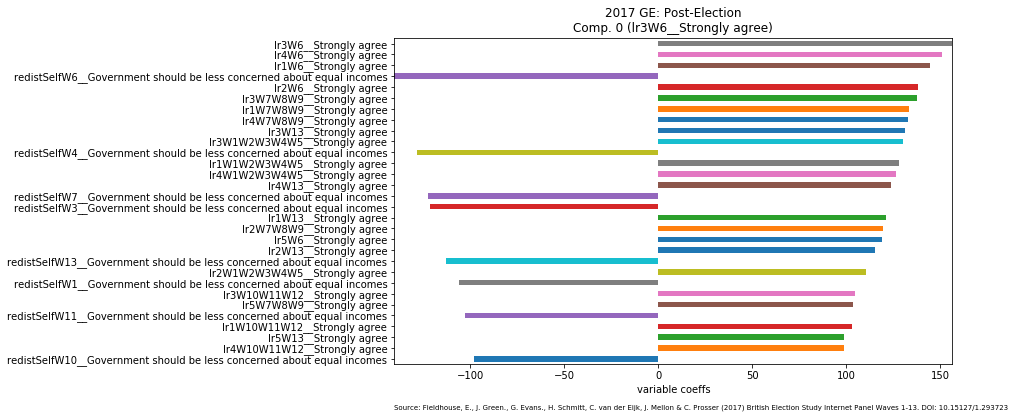

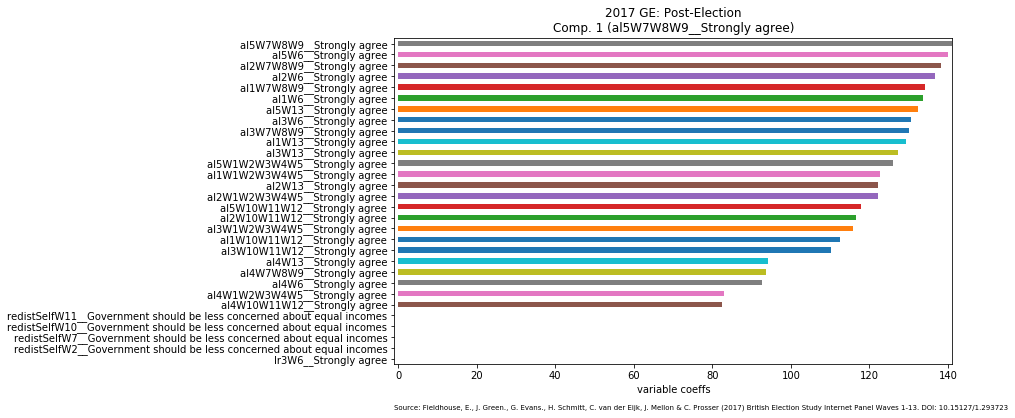

In [162]:
%%time
# normalise data (subtract out the mean, divide through by standard deviation)
BES = BES_vals
clean_feature_set_std = StandardScaler().fit_transform(BES.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES.columns,
                             index   = BES.index      )


# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
# n_components = BES_std.shape[1]
n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = SparsePCA(n_components = n_components, alpha = 32)
#decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [163]:
comp_dict[0].sort_values(by='comp_absmag',ascending=False)

,components_,comp_absmag
lr3W6__Strongly agree,156.372271,156.372271
lr4W6__Strongly agree,150.753544,150.753544
lr1W6__Strongly agree,144.543048,144.543048
redistSelfW6__Government should be less concerned about equal incomes,-140.390717,140.390717
lr2W6__Strongly agree,138.079665,138.079665
lr3W7W8W9__Strongly agree,137.545253,137.545253
lr1W7W8W9__Strongly agree,133.423035,133.423035
lr4W7W8W9__Strongly agree,132.541024,132.541024
lr3W13__Strongly agree,131.312263,131.312263
lr3W1W2W3W4W5__Strongly agree,130.147207,130.147207


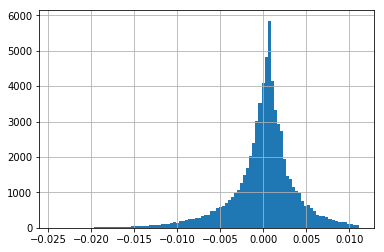

In [164]:
BES_decomp[0].hist(bins=100)

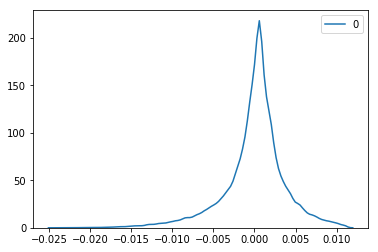

In [165]:
#BES_decomp[0].hist(bins=100)
sns.kdeplot(BES_decomp[0]);

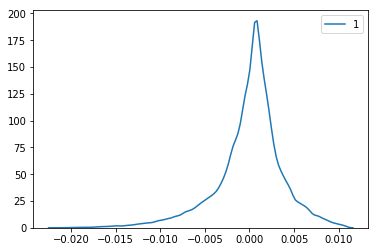

In [166]:
sns.kdeplot(BES_decomp[1]);

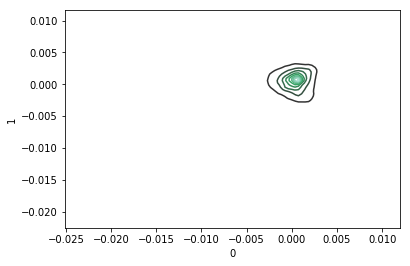

In [167]:
sns.kdeplot(BES_decomp[0],BES_decomp[1]);

In [168]:
raw_gen_lr_vals = BES_decomp[0].copy()
raw_gen_al_vals = BES_decomp[1].copy()


In [169]:
al_corr = BES_reduced.corrwith(BES_decomp[0])
lr_corr = BES_reduced.corrwith(BES_decomp[1])
diff_corr = al_corr.abs()-lr_corr.abs()

# lr  leftRight, redistSelf, cutsTooFar
# al immigEcon, immigCultural, immigSelf, immigrantsWelfareState, overseasAid

In [170]:
diff_corr.drop(al_lr_values).sort_values()

al_scaleW7W8W9__Authoritarian                    -0.685856
al_scaleW6__Authoritarian                        -0.662789
al_scaleW13__Authoritarian                       -0.643936
al_scaleW1W2W3W4W5__Authoritarian                -0.633276
al_scaleW10W11W12__Authoritarian                 -0.607987
overseasAidW11__Strongly agree                   -0.433778
immigrantsWelfareStateW4__Strongly agree         -0.426848
overseasAidW10__Strongly agree                   -0.423197
immigrantsWelfareStateW8__Strongly agree         -0.421311
immigrantsWelfareStateW7__Strongly agree         -0.418514
immigEconW8__Good for economy                    -0.412567
immigEconW7__Good for economy                    -0.409706
harkBackW7__Strongly agree                       -0.404532
immigEconW4__Good for economy                    -0.403425
immigrantsWelfareStateW3__Strongly agree         -0.393524
immigContributeTakeW8__Get more than they pay    -0.388297
immigContributeTakeW7__Get more than they pay    -0.3860

In [ ]:
from scipy import stats

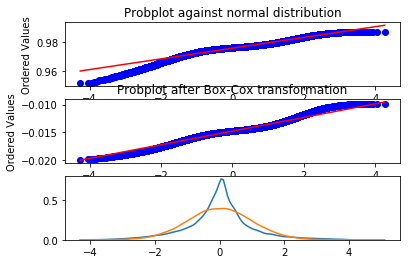

In [171]:
# box cox lr_scale
fig = plt.figure()
ax1 = fig.add_subplot(311)
x = BES_decomp[0].values +BES_decomp[0].values.min()+1
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(312)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
ax3 = fig.add_subplot(313)
xt_std_lr = (xt-xt.mean())/xt.std()
sns.kdeplot(xt_std_lr, ax=ax3);
sns.kdeplot(np.random.normal(size=len(xt_std_lr)), ax=ax3);


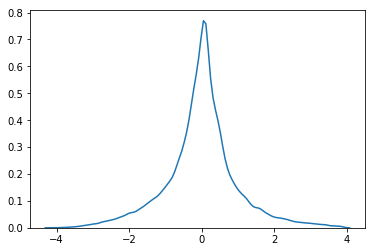

In [172]:
sns.kdeplot(xt_std_lr);

In [173]:
xt_std_lr

array([ 2.11775724, -2.36255919,  0.2255206 , ...,  0.15057217,
       -0.06145697, -0.22217211])

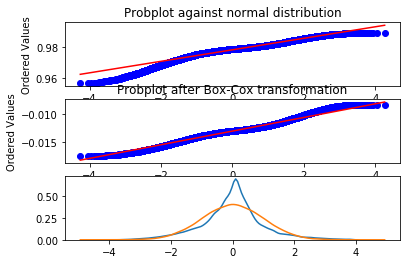

In [174]:
# box cox lr_scale
fig = plt.figure()
ax1 = fig.add_subplot(311)
x = BES_decomp[1].values +BES_decomp[1].values.min()+1
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(312)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
ax3 = fig.add_subplot(313)
xt_std_al = (xt-xt.mean())/xt.std()
sns.kdeplot(xt_std_al, ax=ax3);
sns.kdeplot(np.random.normal(size=len(xt_std_al)), ax=ax3);


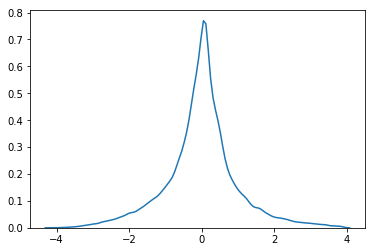

In [176]:
sns.kdeplot(xt_std_lr);

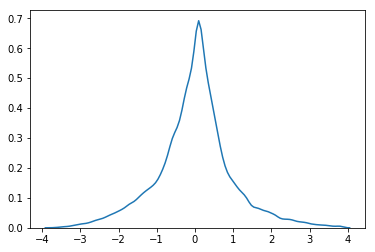

In [175]:
sns.kdeplot(xt_std_al);

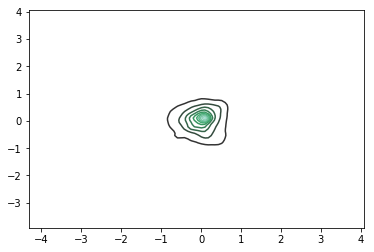

In [177]:
sns.kdeplot(xt_std_lr,xt_std_al);

In [178]:
new_lr_corr = BES_reduced.corrwith(pd.DataFrame(xt_std_lr)[0])

In [179]:
(al_corr-new_lr_corr).sort_values()

ldAngryW4_Yes                                                                                                     -0.046616
conAngryW6_Yes                                                                                                    -0.046114
nonelecParticipation_2W6_Yes                                                                                      -0.046093
tryReduceInequalityGrnW4_Yes                                                                                      -0.045230
conAngryW4_Yes                                                                                                    -0.043888
ldAngryW6_Yes                                                                                                     -0.042664
myPartyWonW6_Yes                                                                                                  -0.042437
tryReduceImmigConW4_Yes                                                                                           -0.042426
particip

In [180]:
lr_uniform = pd.qcut( xt_std_lr, q=50, labels=range(0,50))
al_uniform = pd.qcut( xt_std_al, q=50, labels=range(0,50))

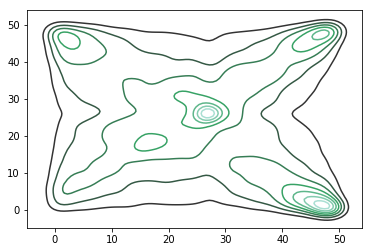

In [181]:
sns.kdeplot(lr_uniform.codes,al_uniform.codes);

In [187]:
# BES_small_data_files
BES_genImmSentiment = BES_Panel[["id"]].copy()
BES_genImmSentiment["genImmigSentiment"] = genImmigSentiment
BES_genImmSentiment["raw_gen_lr_vals"] = raw_gen_lr_vals
BES_genImmSentiment["raw_gen_al_vals"] = raw_gen_al_vals
BES_genImmSentiment["xt_std_lr"] = xt_std_lr
BES_genImmSentiment["xt_std_al"] = xt_std_al
BES_genImmSentiment["lr_uniform"] = list(lr_uniform)
BES_genImmSentiment["al_uniform"] = list(al_uniform)

BES_genImmSentiment.to_csv(BES_small_data_files + "pan_dataset_values"+".csv", index=False)

In [189]:
BES_reduced.corrwith(BES_genImmSentiment["al_uniform"])

turnoutUKGeneralW1__Very likely that I will vote                                                                   -0.045192
turnoutUKGeneralW2__Very likely that I will vote                                                                   -0.046846
turnoutUKGeneralW3__Very likely that I will vote                                                                   -0.030817
turnoutUKGeneralW4__Very likely that I will vote                                                                   -0.039574
turnoutUKGeneralW5__Very likely that I will vote                                                                   -0.039554
turnoutUKGeneralW7__Very likely that I will vote                                                                   -0.048575
turnoutUKGeneralW8__Very likely that I will vote                                                                   -0.051249
turnoutUKGeneralW9__Very likely that I will vote                                                                   -0.040493


In [ ]:
## try another approach to Gaussianize a distribution

In [ ]:
### test gaussianize
# https://github.com/gregversteeg/gaussianize/blob/master/gaussianize.py

In [ ]:
import gaussianize as g

In [ ]:
pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)

In [ ]:
pan_dataset_values["raw_gen_lr_vals"].hist(bins=100)

In [ ]:
out = g.Gaussianize()
out.fit(pan_dataset_values["raw_gen_lr_vals"])  # Learn the parameters for the transformation
lr_normed = out.transform(pan_dataset_values["raw_gen_lr_vals"])  # Transform x to y, where y should be normal
pd.DataFrame(lr_normed).hist(bins=50)

In [ ]:
import gaussianize_2 as g_2

out = g_2.Gaussianize()
out.fit(pan_dataset_values["raw_gen_lr_vals"])
lr_normed = out.transform(pan_dataset_values["raw_gen_lr_vals"])
x_prime = out.normal_to_observed(lr_normed)  # Recover the initial distribution
print(np.allclose(x_prime, pan_dataset_values["raw_gen_lr_vals"]))
pd.DataFrame(lr_normed).hist(bins=50)

##### !!! Doens't finish !!!